In [1]:
import pandas as pd
import numpy as np
heart = pd.read_csv("E:\\Graduation_Project\\datasets\\heart.csv")
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_features = [col for col in heart.columns if col not in categorical_features + ['target']]
heart[categorical_features] = heart[categorical_features].astype(str)



In [2]:
from sklearn.preprocessing import LabelEncoder
features = list(heart.columns)
encoders = {}          # 保存每一列的 LabelEncoder

for f in categorical_features:
    le = LabelEncoder()
    heart[f] = le.fit_transform(heart[f])
    encoders[f] = le    # 留着以后解码

In [3]:
heart_decoded = heart.copy()
for f, le in encoders.items():
    heart_decoded[f] = le.inverse_transform(heart_decoded[f])

In [4]:
from dowhy import gcm
from dowhy.gcm import InvertibleStructuralCausalModel
import networkx as nx

import networkx as nx

graph = nx.DiGraph([
    # 人口统计学特征
    ('age', 'trestbps'), 
    ('age', 'thalach'),
    ('age', 'chol'),
    ('age', 'ca'),

    ('sex', 'trestbps'),
    ('sex', 'thalach'),
    ('sex', 'ca'),
    ('sex', 'chol'),

    # 生理与实验室指标
    ('fbs', 'chol'),

    # 心电图与运动反应
    ('restecg', 'slope'),
    ('slope', 'oldpeak'),

    # 症状与表现
    ('cp', 'exang'),
    ('cp', 'oldpeak'),

    # 运动过程路径
    ('trestbps', 'thalach'),
    ('trestbps', 'exang'),
    ('thalach', 'exang'),

])

# 添加未建边但在图中的变量
graph.add_node('thal')

causal_model = InvertibleStructuralCausalModel(graph)

summary = gcm.auto.assign_causal_mechanisms(causal_model, heart.drop(columns=['target']))
# 3. 拟合模型
gcm.fit(causal_model, heart.drop(columns=['target']))



d:\ANACONDA\envs\dice_XAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting causal mechanism of node thal: 100%|██████████| 13/13 [00:00<00:00, 416.68it/s]


In [5]:
#print(summary)

注意这里使用的是反事实(gcm.counterfactual_samples)而不是干预(gcm.interventional_samples), 两者区别在于，后一个不在乎个体的区别，不会根据个体计算每个人具体的噪声而是用平均噪声替代计算传播影响，后者会对个体样本归因(计算他单独的噪声)，然后固定其他变量，改动想要的变量，生成个体级别的反事实结果。

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import time

def set_seed(s=0):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [7]:

# 预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='error'), categorical_features)
    ]
)


In [8]:
target = heart['target']
train_dataset, test_dataset, y_train, y_test = train_test_split(heart, 
                                                                target,
                                                                test_size=0.2, 
                                                                random_state=42, 
                                                                stratify=heart['target'])

X_train_df = train_dataset.drop('target', axis=1)
X_test_df = test_dataset.drop('target', axis=1)


X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

In [9]:
from tensorflow import keras
def build_simple_dnn():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, activation='relu', input_shape=(31,)))  # 输入31维特征
    model.add(keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
set_seed(1)
model = build_simple_dnn()
model.load_weights('my_model_weights.h5')   # 加载之前保存的权重

In [10]:
# 预测（以X_test为例）
y_pred_prob = model.predict(X_test)

# 概率转类别
y_pred = y_pred_prob.argmax(axis=1)

# 计算准确率
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.3f}')

2/2 [==============================] - 0s 0s/step
Accuracy: 0.836


In [11]:
import dice_ml
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=heart,
                 continuous_features=numeric_features,
                 outcome_name='target')
# Using sklearn backend
m = dice_ml.Model(model=model, 
                  backend="TF2", 
                  func="ohe-min-max")

In [12]:
d.categorical_feature_names

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [13]:
import importlib
import dice_causal_random

importlib.reload(dice_causal_random)


from dice_causal_random import CausalRandom


exp = CausalRandom(d, m, causal_model)
e1 = exp.generate_counterfactuals(
    X_test_df,
    total_CFs=4,
    desired_class="opposite",
    features_to_vary = X_train_df.columns[X_train_df.columns != 'sex'].tolist(),
    sample_size=500
)



100%|██████████| 61/61 [11:58<00:00, 11.77s/it]


In [14]:
heart = pd.read_csv("E:\\Graduation_Project\\datasets\\heart.csv")
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_features = [col for col in heart.columns if col not in categorical_features + ['target']]
heart[categorical_features] = heart[categorical_features].astype(str)

target = heart['target']
train_dataset, test_dataset, y_train, y_test = train_test_split(heart, 
                                                                target,
                                                                test_size=0.2, 
                                                                random_state=42, 
                                                                stratify=heart['target'])

X_train_df = train_dataset.drop('target', axis=1)
X_test_df = test_dataset.drop('target', axis=1)

d = dice_ml.Data(dataframe=heart,
                 continuous_features=numeric_features,
                 outcome_name='target')
# Using sklearn backend
m = dice_ml.Model(model=model, 
                  backend="TF2", 
                  func="ohe-min-max")

In [15]:
exp2 = dice_ml.Dice(d, m,
                   method="random")
e2 = exp2.generate_counterfactuals(
    X_test_df,
    total_CFs=4,
    desired_class="opposite",
    features_to_vary = X_train_df.columns[X_train_df.columns != 'sex'].tolist(),
    sample_size=500
)


100%|██████████| 61/61 [00:27<00:00,  2.21it/s]


In [16]:


cfs_causal = []
cfs_random = []
for i in range(61):
    cfs_causal.append(e1.cf_examples_list[i].final_cfs_df)
    cfs_random.append(e2.cf_examples_list[i].final_cfs_df)

causal_df = pd.concat(cfs_causal, axis=0, ignore_index=True)
random_df = pd.concat(cfs_random, axis=0, ignore_index=True)



In [18]:
from dowhy.gcm import model_evaluation
from sklearn.metrics import f1_score, mean_squared_error, r2_score


def nmse(y_true: np.ndarray, y_pred: np.ndarray, squared: bool = False) -> float:
    """Estimates the Normalized Mean Squared Error (NMSE) based on the given samples. This is, the root mean
    squared error normalized by the variance of the observed values.

    :param y_true: Observed values.
    :param y_pred: Predicted values.
    :param squared: If True, returns the normalized MSE if False, it returns the normalized RMSE.
    :return: The normalized MSE.
    """
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)

    y_std = np.std(y_true)
    mse = mean_squared_error(y_true, y_pred)

    if not squared:
        mse = np.sqrt(mse)

    if y_std == 0:
        return mse

    return mse / (np.var(y_true) if squared else y_std)

model_evaluation.nmse = nmse

Test permutations of given graph: 100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


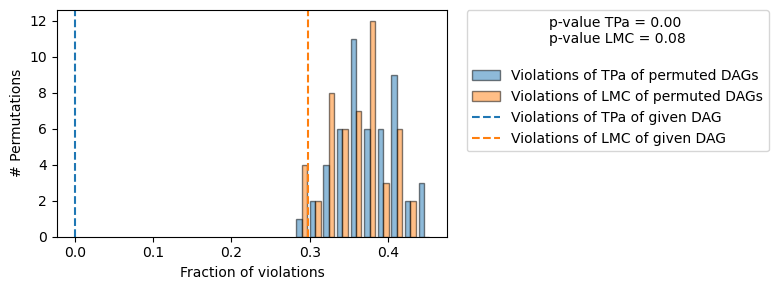

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [22]:


# 3) 评估整体 GCM
result = gcm.evaluate_causal_model(
            causal_model, causal_df,
            compare_mechanism_baselines=False)   # 是否与基线模型比较

print(result)          # 直接打印就能看到人类可读的总结

Test permutations of given graph: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


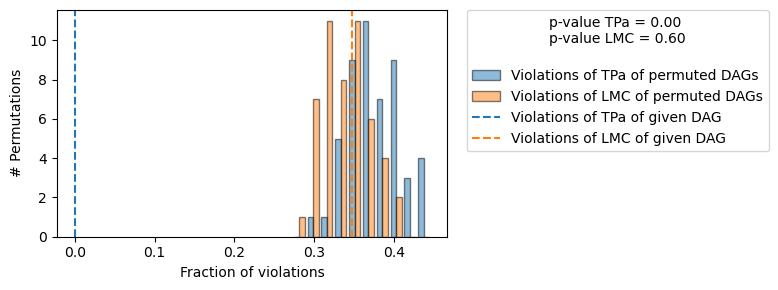

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [20]:
for f in categorical_features:
    le = LabelEncoder()
    random_df[f] = le.fit_transform(random_df[f])
    encoders[f] = le    # 留着以后解码

# 3) 评估整体 GCM
result = gcm.evaluate_causal_model(
            causal_model, random_df,
            compare_mechanism_baselines=False)   # 是否与基线模型比较

print(result)     

In [31]:
print(e1.cf_examples_list[0].intervention_log)
node1_1 = e1.cf_examples_list[0].intervention_log[0, 0][0]
for key in graph.successors(node1_1):
    print('successors of', node1_1, ':', key)
for key in graph.successors('age'):
    print('successors of', 'age', ':', key)

[[('age', 63.0) ('ca', '2')]
 [('ca', '3') ('age', 41.0)]
 [('oldpeak', 0.9) ('ca', '2')]
 [('age', 69.0) ('ca', '2')]]
successors of age : trestbps
successors of age : thalach
successors of age : chol
successors of age : ca
successors of age : trestbps
successors of age : thalach
successors of age : chol
successors of age : ca


In [23]:
e1.cf_examples_list[0].final_cfs_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,0,4,177,253,0,0,139,1,0.0,1,2,3,1
1,41,0,4,164,231,0,0,161,1,0.0,1,2,3,1
2,59,0,4,174,249,0,0,143,1,0.9,1,2,3,1
3,69,0,4,180,259,0,0,133,1,0.0,1,2,3,1


In [33]:
print(causal_model.causal_mechanism('ca'))

Discrete AdditiveNoiseModel using LinearRegression


C:\Users\a1227\AppData\Local\Temp\ipykernel_47136\2699350417.py:4: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.pydot_layout(graph, prog='dot')      # 否则用 pydot


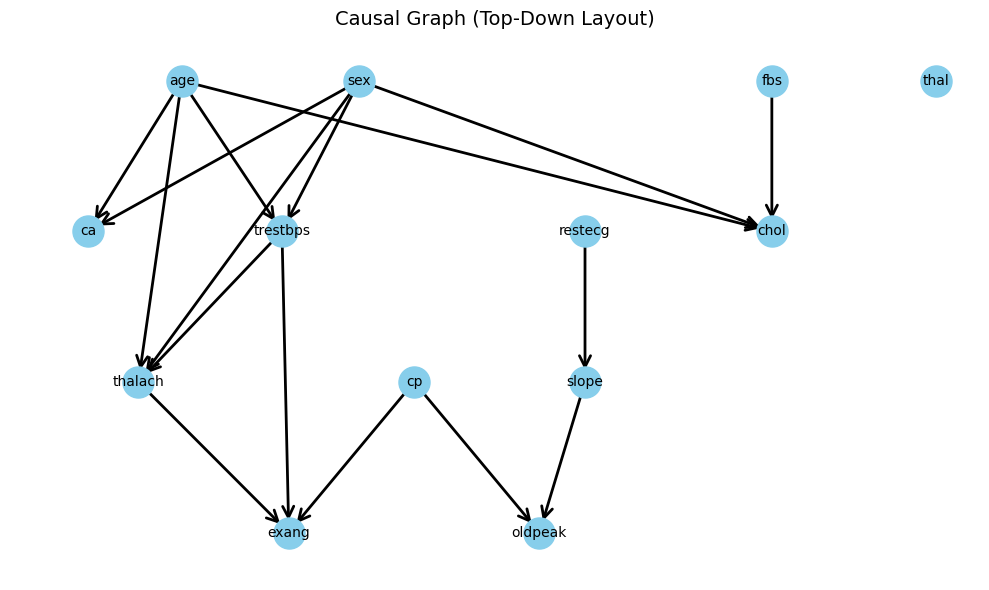

In [24]:
# 可视化因果图
import matplotlib.pyplot as plt

pos = nx.nx_pydot.pydot_layout(graph, prog='dot')      # 否则用 pydot

plt.figure(figsize=(10, 6))

# 画节点
nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='skyblue')

# 画边（从上往下）
nx.draw_networkx_edges(
    graph, pos,
    arrows=True,
    arrowstyle='->',
    arrowsize=20,
    width=2
)

# 标签
nx.draw_networkx_labels(graph, pos, font_size=10)

plt.title("Causal Graph (Top-Down Layout)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [25]:
def store_cfs(e1, length):
    list_cfs = []
    for i in range(length):
        orig_df = e1.cf_examples_list[i].test_instance_df
        cfs_df = e1.cf_examples_list[i].final_cfs_df
        cfs_df['oldpeak'] = cfs_df['oldpeak'].round(1)
        for feature in heart.columns:
            orig_df[feature] = orig_df[feature].astype(heart[feature].dtype)
            cfs_df[feature] = cfs_df[feature].astype(heart[feature].dtype)
        list_cfs.append((
            orig_df,
            cfs_df
              ))
    return list_cfs



In [26]:
from XAI_metrics import calc_valid, calc_sparsity, calc_continuous_proximity, \
    calc_categorical_proximity, calc_manifold_distance, calc_cf_num

cfs_causal = store_cfs(e1, 1)
valid_causal = calc_valid(cfs_causal, model, preprocessor)
sparsity_causal = calc_sparsity(cfs_causal, categorical_features)
con_proximity_causal = calc_continuous_proximity(cfs_causal, numeric_features)
cat_proximity_causal = calc_categorical_proximity(cfs_causal, categorical_features)
manifold_causal = calc_manifold_distance(cfs_causal, heart, categorical_features)
cf_num_causal = calc_cf_num(cfs_causal)

In [27]:
print(valid_causal)
print(sparsity_causal)
print(con_proximity_causal)
print(cat_proximity_causal)
print(manifold_causal)
print(cf_num_causal)

1.0
0.5256696428571428
1.5616666666666665
0.125
11.946565921200776
4.0


In [28]:
e1.cf_examples_list[0].test_instance_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,59,0,4,174,249,0,0,143,1,0.0,1,0,3,0


In [29]:
e1.cf_examples_list[0].final_cfs_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,0,4,177,253,0,0,139,1,0.0,1,2,3,1
1,41,0,4,164,231,0,0,161,1,0.0,1,2,3,1
2,59,0,4,174,249,0,0,143,1,0.9,1,2,3,1
3,69,0,4,180,259,0,0,133,1,0.0,1,2,3,1


: 